## Measure the projected (w$_p$[r$_p$]) and 3D auto-correlation function ($\xi$[s]) of the LBG galaxy mock

I use Corrfunc (https://corrfunc.readthedocs.io/en/master/install.html) to measure the 2PCF from the X/Y/Z coordinates in the LBG galaxy mock created in 'createMOCK.ipynb', which is already in redshift-space. This requires creating a random catalog, which is simple here since we are using a simulation box with no special masks (just randomly fill the box with points). I have included how I created the random mock below, but not the random file as it is too large to store in the repository.

Note that running these calculations in Jupyter Notebook is slow. Better to copy and paste into your own python program and run through your terminal.

___________________________________________________________________________________________

Measure projected correlation function.

In [1]:
import numpy as np
from Corrfunc.theory.DDrppi import DDrppi
from Corrfunc.io import read_catalog
from Corrfunc.utils import convert_rp_pi_counts_to_wp

DATAdir = './data'
MEASdir = './measured'
FILEdata = '/Uchuu_xyz_sSFR_VLTS_sftz.dat'
X, Y, Z = np.loadtxt(DATAdir+FILEdata,unpack=True)
N = len(X)
Lbox = 2000.0

createRAND = False
if createRAND:
    Ntimes = 50
    Nrand = Ntimes*Ngal
    seed = 42
    np.random.seed(seed)
    Xrand = np.random.uniform(0, Lbox, Nrand)
    Yrand = np.random.uniform(0, Lbox, Nrand)
    Zrand = np.random.uniform(0, Lbox, Nrand)
 
    now = datetime.datetime.now()
    NOW = now.strftime("%Y-%m-%d")
    commentsR = ["# Randoms for Uchuu UM uniformly distributed in box with seed number {} by KSM on {}".format(seed,NOW),"# Nrand is {}xNgal".format(Ntimes)]
    headerR = '\n'.join(commentsR)
 
    RANDdat = np.vstack((Xrand,Yrand,Zrand)).T
    FILErand = '/Uchuu_RANDxyz.dat'
    np.savetxt(DATAdir+FILErand,RANDdat,header=headerR)
else:
    FILErand = '/Uchuu_RANDxyz.dat'

Xrand,Yrand,Zrand = np.loadtxt(DATAdir+FILErand,unpack=True)
Nrand = len(Xrand)


nthreads = 4
pimax = 100
nrpbins = 13
rpmin = -1.0
rpmax = 1.5
bins = np.logspace(rpmin, rpmax, nrpbins + 1)
autocorr = 1
DD_counts = DDrppi(autocorr, nthreads, pimax, bins, X, Y, Z, output_rpavg=True, boxsize=Lbox)
autocorr = 0
DR_counts = DDrppi(autocorr, nthreads, pimax, bins, X, Y, Z, X2=Xrand, Y2=Yrand, Z2=Zrand, output_rpavg=True, boxsize=Lbox)
autocorr = 1
RR_counts = DDrppi(autocorr, nthreads, pimax, bins, Xrand, Yrand, Zrand, output_rpavg=True, boxsize=Lbox)

wp = convert_rp_pi_counts_to_wp(N, N, Nrand, Nrand, DD_counts, DR_counts, DR_counts, RR_counts, nrpbins, pimax)
for w in wp: print("{0:10.6f}".format(w))

rp = bins[0:-1]+(bins[1:]-bins[:-1])/2.


import datetime
now = datetime.datetime.now()
NOW = now.strftime("%Y-%m-%d")
wp_out = np.vstack((rp,wp)).T
comments = ["# Measurement of Uchuu UM projected correlation function of data in {} by KSM on {}".format(FILEdata,NOW),"# Random is {}".format(FILErand)]
header = '\n'.join(comments)

[Warning] The CPU supports SSE4.2 but the compiler does not.  Can you try another compiler?
[Warning] The CPU supports SSE4.1 but the compiler does not.  Can you try another compiler?


245.566616
 69.770715
 50.764013
 45.603102
 37.484250
 22.191742
 22.212469
 15.254452
 12.950907
  8.394499
  5.673680
  3.340458
  1.727833


In [2]:
np.savetxt(MEASdir+'/Uchuu_wp_sSFR_VLTS_sftz.dat',wp_out,header=header)

Measure 3D autocorrelation function, $\xi$(s), in redshift-space.

In [3]:
from Corrfunc.theory.DD import DD
from Corrfunc.utils import convert_3d_counts_to_cf
import traceback
traceback.print_exc()

nthreads = 5

rmin = -0.7
rmax = 1.477
nrbins = 11

bins = np.logspace(rmin, rmax, nrbins + 1)
ravgOUT = True

autocorr = 1
DD_counts = DD(autocorr, nthreads, bins, X, Y, Z, output_ravg=ravgOUT, boxsize=Lbox)
autocorr = 0
DR_counts = DD(autocorr, nthreads, bins,X, Y, Z,X2=Xrand, Y2=Yrand, Z2=Zrand, output_ravg=ravgOUT, boxsize=Lbox)
autocorr = 1
RR_counts = DD(autocorr, nthreads, bins, Xrand, Yrand, Zrand, output_ravg=ravgOUT,boxsize=Lbox)

cf = convert_3d_counts_to_cf(N, N, Nrand, Nrand,DD_counts, DR_counts,DR_counts, RR_counts)

for xi in cf: print("{0:10.6f}".format(xi))

r = DD_counts['ravg']

import datetime
now = datetime.datetime.now()
NOW = now.strftime("%Y-%m-%d")
xi3D_out = np.vstack((r,cf)).T
comments = ["# Measurement of Uchuu UM 3D 2-point correlation function of data in {} by KSM on {}".format(FILEdata,NOW),"# Random is {}".format(FILErand)]
header = '\n'.join(comments)


NoneType: None


 53.939693
 26.980682
 16.423601
  9.370849
  4.712357
  2.310629
  1.141857
  0.566774
  0.272949
  0.112637
  0.042209


In [4]:
np.savetxt(MEASdir+'/Uchuu_xi3D_sSFR_VLTS_sftz.dat',xi3D_out,header=header)

----------------------------------------

Now we will plot the results to compare to the observations from Bielby+13 (link to paper in the respository Readme). These data points were estimated using a plot digitizer (https://automeris.io/wpd/) and are only sufficient for a 'by-eye' comparision.

In [5]:
# Uchuu uses the following cosmology: 
# Planck2015 (table 4, rightmost column)
#Ω_m = 0.3089 Ω_L = 0.6911 h = 0.6774
#σ_8 = 0.8159 Ω_b = 0.0486 ns = 0.9667
#Linear Power Spectrum
#z_init = 127 (2LPT)
## Uchuu is 2000 Mpc/h on a side 
Om0 = 0.3089
h = 0.6774
H0 = 100*h
z_sim = 2.95
Lbox = 2000 # Mpc/h
ns = 0.9667
sigma8 = 0.8159
Ob0 = 0.0486
Tcmb0 = 2.718
LOS = 'z'

import datetime
now = datetime.datetime.now()
NOW = now.strftime("%Y-%m-%d")

In [6]:
rU,xi3dU = np.loadtxt(MEASdir+'/Uchuu_xi3D_sSFR_VLTS_sftz.dat',unpack=True)
rpCF,wpCF = np.loadtxt(MEASdir+'/Uchuu_wp_sSFR_VLTS_sftz.dat',unpack=True)
# These errors are not actual only as estimation of the diagonal to start with prior to calculating full covariance.
xi3d_errU = np.linspace(0.1,0.4,len(rU))[::-1]
wp_errU = np.linspace(0.5,0.7,len(rpCF))[::-1]


In [7]:
# By-eye (digitized) from Fig. 24 of Bielby+13
rB13,xi3dB13 = np.loadtxt(MEASdir+'/VLTS_Bielby13_xi3D.dat',unpack=True)
lowERR,hiERR = np.loadtxt(MEASdir+'/VLTS_Bielby13_xi3D_errs.dat',unpack=True).T
xi3dB13_err = np.array(list(zip(lowERR, hiERR))).T

In [8]:
# By-eye values from Fig. 20 of Bielby+13
rpB13 = np.array([0.2,0.3,0.5,0.75,1.1,2.0,3.1,4.8,8.0,12,20])
wpB13prp = np.array([1200.0,75.,180.,45.,20.,4.,10.,4.0,2.5,1.5,0.4])
errB13 = np.array([800.,175.,120.,45.,9.6,11.,2.6,1.,1.0,1.0,0.6])
lower_error =  np.array([400.,45.,90.,30.,10.,2.5,2.0,1.0,2.,2.0,0.2])
upper_error =  np.array([800.,175.,120.,45.,9.6,11.,2.6,1.,1.0,1.0,0.6])
asymmetric_error = np.array(list(zip(lower_error, upper_error))).T

In [9]:
def wpMOD(r0,gam):
    C = (gamma(0.5)*gamma((gam-1)/2)/gamma(gam/2))
    wp = C*r0**gam*rpB13**(1-gam)
    return wp

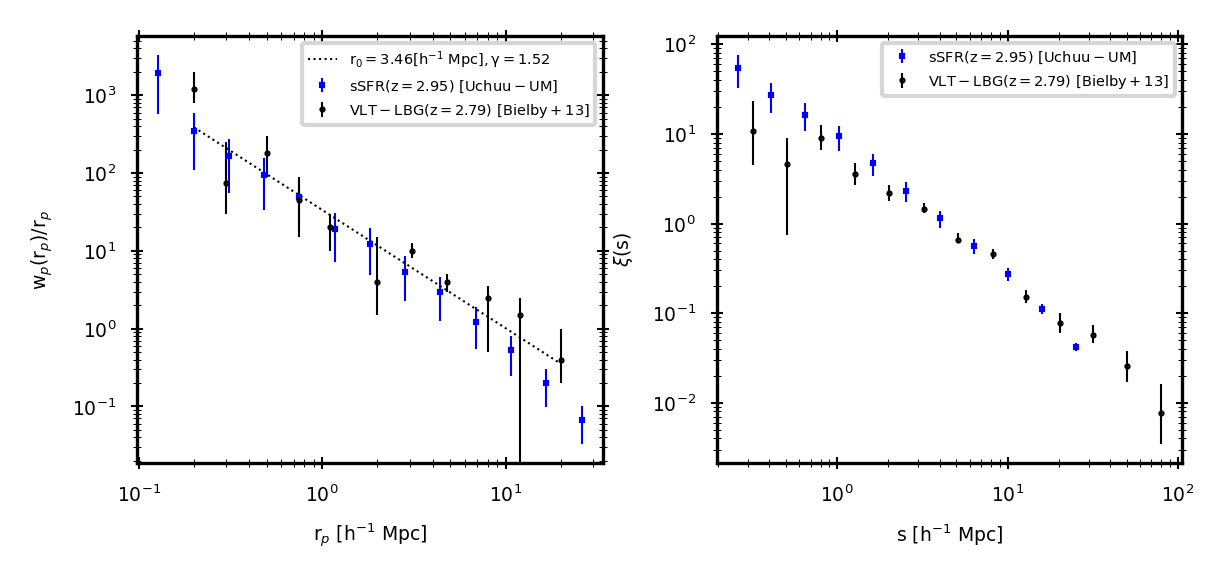

In [10]:
import matplotlib.pyplot as plt
from scipy.special import gamma, factorial
# w_theta (angular correlation function is approx. wp/delta with delta being the shell width and is true as R (or r_p) << delta, this is a model to account for RSD, or rather to neglect RSD. On scales much smaller than the shell width, delta, the effect of RSD is reduced and w_angular(R) is proporational to w_p(R).

fig, axs = plt.subplots(1,2, sharex=False,sharey=False,dpi=300,figsize=(4.,1.8))
fig.subplots_adjust(top=0.962,bottom=0.171,left=0.092,right=0.963,wspace=0.245,hspace=0.0)
(ax1,ax2) = axs

#ax1.plot(rpCF,wpCF/rpCF,color='cyan',ls='-',lw=1.0,label=r'$\rm CF sSFR (z=2.95)~[Uchuu-UM]$')
ax1.errorbar(rpCF,wpCF/rpCF,yerr=wp_errU*wpCF/rpCF,color='b',linewidth=0.5,ls='',markersize=0.5,marker='s',label=r'$\rm sSFR (z=2.95)~[Uchuu-UM]$')
ax1.plot(rpB13,wpMOD(3.46,1.52)/rpB13,color='k',lw=0.5,ls= ':',label=r'$\rm r_0=3.46 [h^{-1}~Mpc],\gamma=1.52$')
ax1.errorbar(rpB13,wpB13prp,yerr=asymmetric_error,linewidth=0.5,markersize=1,color='k',marker='.',ls='',label=r'$\rm VLT-LBG (z=2.79)~[Bielby+13]$')
ax1.tick_params('both', top=True,right=True,direction='inout',length=3, width=0.5, which='major',labelsize=4.5)
ax1.tick_params('both', top=True,right=True,direction='inout',length=2, width=0.25, which='minor')
ax1.set_ylabel(r'w$_p$(r$_p$)/r$_p$',fontsize=4.5)
ax1.set_xlabel(r'r$_p$ [$\rm h^{-1}~Mpc$]',fontsize=4.5)
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.legend(loc='upper right',fontsize=3.5)

ax2.errorbar(rU,xi3dU,yerr=xi3d_errU*xi3dU,color='b',linewidth=0.5,ls='',markersize=0.5,marker='s',label=r'$\rm sSFR (z=2.95)~[Uchuu-UM]$')
#axs.plot(rpB13,wpMOD(3.46,1.52)/rp,color='k',lw=0.5,ls= ':',label=r'$\rm r_0=3.46 [h^{-1}~Mpc],\gamma=1.52$') 
ax2.errorbar(rB13,xi3dB13,yerr=xi3dB13_err,linewidth=0.5,markersize=1,color='k',marker='.',ls='',label=r'$\rm VLT-LBG (z=2.79)~[Bielby+13]$')
ax2.tick_params('both', top=True,right=True,direction='inout',length=3, width=0.5, which='major',labelsize=4.5)
ax2.tick_params('both', top=True,right=True,direction='inout',length=2, width=0.25, which='minor')
ax2.set_ylabel(r'$\xi$(s)',fontsize=4.5)
ax2.set_xlabel(r's [$\rm h^{-1}~Mpc$]',fontsize=4.5)
ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.legend(loc='upper right',fontsize=3.5)
plt.show()